In [1]:
import numpy as np
import pandas as pd
from IPython.display import display


import plotly
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
plotly.plotly.sign_in('spersad', 'MwbO3xbqh2Mv6sfhCma7')
import plotly.graph_objs as go

import logging as log
log.getLogger().setLevel(log.INFO)

import tensorflow as tf

In [2]:
def load_bitvectors(paths, unique=False):
    '''
    Given a pandas dataframe with headings Read_name Binary_vector N_mutations Reference_name Start_position
    load only the bitvectors as a numpy array of integers
    @param: paths - a list of paths to bitvector file for each cluster
    @return: bitreads - an array of bitvectors, not corrected for correlation between bases
    '''
    dfs = []
    for (i,path) in enumerate(paths):
        df = pd.read_csv(path, sep='\t', na_values='?')
        df['Label'] = i
        dfs.append(df)
    df = pd.concat(dfs)
    print('Loaded clusters with shape {0} before removing excess NaN values.'.format(df.shape))
    df = df[df.isnull().sum(axis=1)<0.3*df.shape[1]]
    # Cast NaN to zero for analysis
    df.fillna(0, inplace=True)
    print('Loaded clusters with shape {0} after removing excess NaN values.'.format(df.shape))
    if unique:
        df.drop_duplicates(inplace=True)
        print('Loaded clusters with shape {0} after removing duplicates.'.format(df.shape))
    df = df.sample(frac=1)
    Y = df['Label']
    df.drop('Label', inplace=True)
    return df.as_matrix(), Y

In [3]:
def performMDS(X, Y, num_examples=2000,metric='euclidean'):
    from sklearn.manifold import MDS
    model = MDS(n_components=2, max_iter=3000, dissimilarity=metric)
    log.info('Defined model')
    if metric !='precomputed':
        X = X[:num_examples]
        Y = Y[:num_examples]
    log.info('Performing MDS on data with shape {0}'.format(X.shape))         
    embeddedX = model.fit_transform(X)
    log.info('Created embedding')

    # Scatter plot to visualize embedded data
    # Create a trace
    trace = go.Scatter(
        x = embeddedX[:,0],
        y = embeddedX[:,1],
        mode = 'markers',
        marker=dict(
            size='5',
            color = Y, # color points by label they belong to
            colorscale= [[0, '#dd2c4f'], [1, '#3d6fcc']],
        ),
        text = [str(x) for x in X]
    )

    data = [trace]
    
    layout = go.Layout(
        title='MDS Embedding of Clusters in 2D Space',
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='MDS-embedding')
    
    log.info('Plotted data')

In [4]:
X_real, Y_real = load_bitvectors(['riboA_real.txt','riboC_real.txt'], unique=True)

Loaded clusters with shape (939354, 41) before removing excess NaN values.
Loaded clusters with shape (804220, 41) after removing excess NaN values.
Loaded clusters with shape (2102, 41) after removing duplicates.


In [12]:
def run_autoencoder(simX, simY, n_hidden_1=128, n_hidden_2=12, learning_rate=0.01, training_epochs=2000, BATCH_SIZE=200, draw_examples=False, draw_dim1=20,draw_dim2=20):
    import matplotlib.pyplot as plt
    %matplotlib inline

    # Parameters
    display_step = 100
    n_input = simX.shape[1]   # length of input read
    
    X = tf.placeholder("float64", [None, n_input])

    encoder_W1 = tf.Variable(tf.random_normal([n_input, n_hidden_1], dtype="float64"), name="encoder_W1")
    encoder_W2 =  tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], dtype="float64"), name="encoder_W2")
    weights = {
        'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1], dtype="float64")),
        'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input], dtype="float64")),
    }

    encoder_b1 = tf.Variable(tf.random_normal([n_hidden_1], dtype="float64"), name="encoder_b1"),
    encoder_b2 = tf.Variable(tf.random_normal([n_hidden_2], dtype="float64"), name="encoder_b2"),
    biases = {
        'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1], dtype="float64")),
        'decoder_b2': tf.Variable(tf.random_normal([n_input], dtype="float64")),
    }


    # Building the encoder
    def encoder(x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, encoder_W1),
                                       encoder_b1))
        # Decoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, encoder_W2),
                                       encoder_b2))
        return layer_2


    # Building the decoder
    def decoder(x):
        # Encoder Hidden layer with ReLU activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                       biases['decoder_b1']))
        # Decoder Hidden layer with ReLU activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                       biases['decoder_b2']))
        return layer_2

    # Construct model
    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    
    NUM_BATCHES = simX.shape[0]//BATCH_SIZE

    costs = []
    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        log.info('Training Autoencoder')
        for epoch in range(training_epochs):
            # Loop over all batches
            for i in range(NUM_BATCHES):
                batch_xs= simX[BATCH_SIZE*i : BATCH_SIZE*(i+1)]
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
                
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch),
                      "cost=", "{:.9f}".format(c))
                costs.append(c)

        log.info("Optimization Finished!")
         # Applying encode and decode over test set
        encoded, encode_decode = sess.run(
            [encoder_op, y_pred], feed_dict={X: simX})
        
        encode_W1_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_W1:0"][0])
        encode_W2_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_W2:0"][0])
        
        encode_b1_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_b1:0"][0])
        encode_b2_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_b2:0"][0])
     
    log.info('Encoded data has dimension {0} and {1} samples.'.format(encoded.shape[1],encoded.shape[0]))

    return costs, encoded, encode_decode, n_hidden_2, encode_W1_vals, encode_W2_vals, encode_b1_vals, encode_b2_vals


In [13]:
costs, encoded, reconstruct, _, _, _, _, _ = run_autoencoder(X_real, Y_real, training_epochs=1100, draw_examples=True, draw_dim1=41,draw_dim2=1)

INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.452058476
Epoch: 0100 cost= 0.036847568
Epoch: 0200 cost= 0.007441295
Epoch: 0300 cost= 0.004768412
Epoch: 0400 cost= 0.003658658
Epoch: 0500 cost= 0.002195948
Epoch: 0600 cost= 0.002195610
Epoch: 0700 cost= 0.002195484
Epoch: 0800 cost= 0.002195419
Epoch: 0900 cost= 0.002195377
Epoch: 1000 cost= 0.002195347


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 128 and 2102 samples.


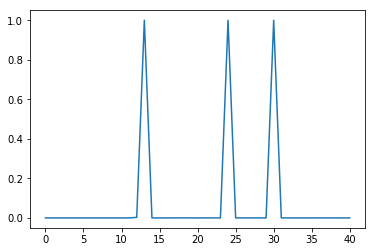

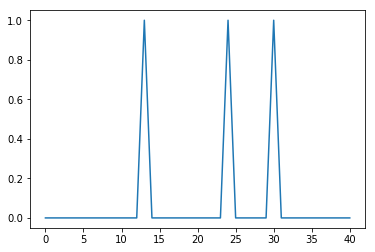

In [21]:
import matplotlib.pyplot as plt
plt.plot(reconstruct[0])
plt.show()
plt.plot(X_real[0])
plt.show()

In [22]:
costs2, encoded2, reconstruct2, _, _, _, _, _ = run_autoencoder(X_real, Y_real, n_hidden_1=256, n_hidden_2=2)

INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.434920627
Epoch: 0100 cost= 0.097542464
Epoch: 0200 cost= 0.077392656
Epoch: 0300 cost= 0.076512518
Epoch: 0400 cost= 0.068577255
Epoch: 0500 cost= 0.066239919
Epoch: 0600 cost= 0.045747326
Epoch: 0700 cost= 0.050838484
Epoch: 0800 cost= 0.045127524
Epoch: 0900 cost= 0.043128824
Epoch: 1000 cost= 0.050288785
Epoch: 1100 cost= 0.043104547
Epoch: 1200 cost= 0.042314707
Epoch: 1300 cost= 0.041414163
Epoch: 1400 cost= 0.041524672
Epoch: 1500 cost= 0.040511325
Epoch: 1600 cost= 0.039959102
Epoch: 1700 cost= 0.043803472
Epoch: 1800 cost= 0.039265527
Epoch: 1900 cost= 0.041457142


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.


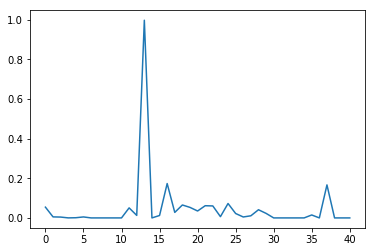

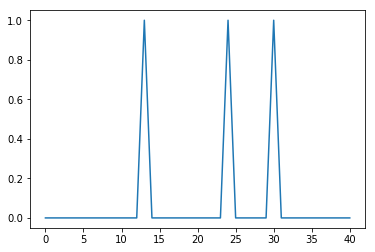

In [29]:
import matplotlib.pyplot as plt
plt.plot(reconstruct2[0])
plt.show()
plt.plot(X_real[0])
plt.show()

[  8.27947886e-01   3.86159840e-04]


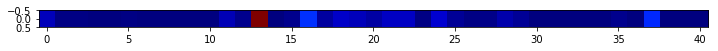

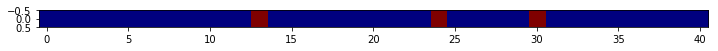

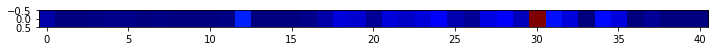

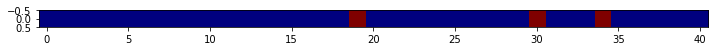

In [68]:
import matplotlib.pyplot as plt
import numpy as np

print(X_tr[0])

plt.figure(figsize=(12,12))
plt.imshow(reconstruct2[0].reshape(1,-1), cmap='jet', interpolation='nearest')
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(X_real[0].reshape(1,-1), cmap='jet', interpolation='nearest')
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(reconstruct2[1979].reshape(1,-1), cmap='jet', interpolation='nearest')
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(X_real[1979].reshape(1,-1), cmap='jet', interpolation='nearest')
plt.show()


# print(reconstruct2[0])
# trace = go.Heatmap(z=[reconstruct2[0].reshape(1,-1),X_tr[0].reshape(1,-1)])
# data=[trace]
# layout = go.Layout(
#     title='Evolution of Cost Function for Autoencoder',
# )

# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='MDS-embedding')


In [25]:
X_tr = encoded2
# Create a trace
trace = go.Scatter(
    x = X_tr[:,0],
    y = X_tr[:,1],
    mode = 'markers',
    marker=dict(
        size='5',
        color = Y_real, # color points by label they belong to
        colorscale= [[0, '#dd2c4f'], [1, '#3d6fcc']],
    ),
    text = [str(x) for x in X_tr]
)

data = [trace]

layout = go.Layout(
    title='<b>Hierarchical Clustering of MDS 5NN Embedded Data</b>',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='MDS-embedding')


In [86]:
def run_DEC(simX, simY, encoding=True, learning_rate = 1e-2, N_CLUSTERS=2, ALPHA=1, DEC_training_steps=2000, draw_examples=False, draw_dim1=20, draw_dim2=20):

    tf.reset_default_graph()
  
    n_samples = simX.shape[0]

    # Create a placeholder for inputting training X data 
    input_X = tf.placeholder("float64", [None, simX.shape[1]], name="Input_X")

    if encoding=='ae':
        # Run auto-encoder to generate embedded data
        costs, encoded, reconstruction, DIM_Z, encode_W1_vals, encode_W2_vals, encode_b1_vals, encode_b2_vals = run_autoencoder(simX,simY,draw_examples=draw_examples,n_hidden_1=256, n_hidden_2=2,draw_dim1=draw_dim1, draw_dim2=draw_dim2)

        # Building the encoder
        encoder_W1 = tf.Variable(encode_W1_vals, name="encoder_W1")
        encoder_W2 =  tf.Variable(encode_W2_vals, name="encoder_W2")
        encoder_b1 = tf.Variable(encode_b1_vals, name="encoder_b1"),
        encoder_b2 = tf.Variable(encode_b2_vals, name="encoder_b2"),   
        def encoder(x):
            # Encoder Hidden layer with sigmoid activation #1
            layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, encoder_W1),
                                        encoder_b1))
            # Decoder Hidden layer with sigmoid activation #2
            layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, encoder_W2),
                                           encoder_b2))
            return layer_2
        X = encoder(input_X)

    elif encoding=='tsne':
        print('Performing TSNE')
        DIM_Z = 2
        from sklearn.manifold import TSNE
        model = TSNE(n_components=N_CLUSTERS, perplexity = 30, random_state=0) # fit into 2D space
        encoded = model.fit_transform(simX)
        X = encoded
    else:
        X = input_X
        encoded = simX
        DIM_Z = simX.shape[1]
        
    # Initialize mu by k means, return a numpy array of shape (N_CLUSTERS, DIM_Z)
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(encoded)
    mu_init = kmeans.cluster_centers_
    
#     #Debugging mu_init
#     mu_init = np.array([[0,1],[4,5]])

    print('Kmeans accuracy: {0}'.format(100*sum(kmeans.predict(encoded)==simY)/len(simY)))
    print('Initialize {0} clusters with dimensions {1}'.format(N_CLUSTERS, encoded.shape[1]))

    # Create another Variable initialized with the original cluster centers.
    Mu = tf.Variable(mu_init, name="Input_Mu", dtype="float64")
    
    
    X_1 = tf.reshape(X, [n_samples, DIM_Z]) 
    c = tf.tile(X_1, tf.constant([1, N_CLUSTERS]))
    X_reshape = tf.reshape(c,[n_samples,N_CLUSTERS,DIM_Z], name="X_reshape")

    #Reshape Mu into a dimension befitting the number of data points
    Mu_tile = tf.tile(Mu, tf.constant([n_samples, 1]), name="Mu_tile")
    Mu_reshape = tf.reshape(Mu_tile, [n_samples,N_CLUSTERS,DIM_Z], name="Mu_reshape")
    a = tf.squared_difference(Mu_reshape, X_reshape)
    b = tf.reduce_sum(tf.squared_difference(Mu_reshape, X_reshape), 2)
    Q = tf.pow(tf.reduce_sum(tf.squared_difference(Mu_reshape, X_reshape), 2)/ALPHA + 1, -0.5*(ALPHA+1))

    Q_norm = Q/tf.reduce_sum(Q, 1, keep_dims=True) ## FINAL Q_ij matrix, where position (i,j) is q_ij

    # Compute auxiliary probability distribution P

    # p_ij = q_ij^2/f_j , where f_j is the sum of q_ij over i (column-sum)
    P = tf.pow(Q_norm,2)/ tf.reduce_sum(Q_norm, 0)
    # Now normalize by cluster (row)
    P_norm = P/tf.reduce_sum(P, 1, keep_dims=True) ## This gives the responsibilities of each cluster

    KL_matrix = tf.multiply(P_norm, tf.log(tf.div(P_norm, Q_norm)))
    cost = -(tf.reduce_sum(KL_matrix))

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()

    costs = []
    similarities = []
    probabilities = []
    clusters = []
    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)
        for i in range(DEC_training_steps):
            _, c, x, p, m_t, m_r, m, q_norm = sess.run([optimizer, cost, X, P_norm,Mu_tile, Mu_reshape, Mu, Q_norm], feed_dict={input_X:simX})
            costs.append(c)
            if (i%100==1):
                print('Cost at epoch {0} : {1}'.format(i, c))
                preds = np.argmax(p, axis=1)
                acc = 100*sum(simY==preds)/len(preds)
                print('Accuracy :{0}'.format(acc))
                probabilities.append(p)
                clusters.append(m)
    print('Optimization complete!')
    preds = np.argmax(probabilities[-1], axis=1)
    acc = 100*sum(simY==preds)/len(preds)
    print('Final accuracy: {0}'.format(acc))
    return costs, probabilities, clusters, x

In [87]:
cost1, prob1, cluster1, x1 = run_DEC(X_real, Y_real, encoding='ae', DEC_training_steps=2000)

INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.438501434
Epoch: 0100 cost= 0.072721276
Epoch: 0200 cost= 0.070254535
Epoch: 0300 cost= 0.071353797
Epoch: 0400 cost= 0.067716220
Epoch: 0500 cost= 0.049611565
Epoch: 0600 cost= 0.048518326
Epoch: 0700 cost= 0.050035171
Epoch: 0800 cost= 0.046847691
Epoch: 0900 cost= 0.045497282
Epoch: 1000 cost= 0.046510715
Epoch: 1100 cost= 0.043971596
Epoch: 1200 cost= 0.043791038
Epoch: 1300 cost= 0.045756911
Epoch: 1400 cost= 0.044360039
Epoch: 1500 cost= 0.045196997
Epoch: 1600 cost= 0.042125835
Epoch: 1700 cost= 0.042953218
Epoch: 1800 cost= 0.042355088
Epoch: 1900 cost= 0.042343002


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.


Kmeans accuracy: 38.34443387250238
Initialize 2 clusters with dimensions 2
Cost at epoch 1 : -43.64616216843221
Accuracy :38.867745004757374
Cost at epoch 101 : -166.5756963006042
Accuracy :34.776403425309226
Cost at epoch 201 : -167.4987249627506
Accuracy :34.776403425309226
Cost at epoch 301 : -167.576435446815
Accuracy :34.776403425309226
Cost at epoch 401 : -167.59317849797264
Accuracy :34.776403425309226
Cost at epoch 501 : -167.59918909591445
Accuracy :34.776403425309226
Cost at epoch 601 : -167.6021835034666
Accuracy :34.776403425309226
Cost at epoch 701 : -167.6038657924574
Accuracy :34.776403425309226
Cost at epoch 801 : -167.60489912293946
Accuracy :34.776403425309226
Cost at epoch 901 : -167.60558468758842
Accuracy :34.776403425309226
Cost at epoch 1001 : -167.60606541183935
Accuracy :34.776403425309226
Cost at epoch 1101 : -167.60641644751428
Accuracy :34.776403425309226
Cost at epoch 1201 : -167.60668095796646
Accuracy :34.776403425309226
Cost at epoch 1301 : -167.60688462

In [88]:
X_tr = x1
print(X_tr[:,0])
# Create a trace
trace = go.Scatter(
    x = X_tr[:,0],
    y = X_tr[:,1],
    mode = 'markers',
    marker=dict(
        size='5',
        color = Y_real, # color points by label they belong to
        colorscale= [[0, '#dd2c4f'], [1, '#3d6fcc']],
    ),
    text = [str(x) for x in X_tr]
)

data = [trace]

layout = go.Layout(
    title='Embedded Data',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='MDS-embedding')


[  4.96771382e-12   9.99999908e-01   6.63096140e-13 ...,   1.31813255e-11
   5.48491886e-10   1.62570586e-14]


In [89]:
def plot_violin(cluster, simY, one=1, zero=0):
    from plotly import tools
    from plotly.tools import FigureFactory as ff

    ones = cluster[np.where(simY == one)]
    zeros = cluster[np.where(simY==zero)]
    
    c0_dist = zeros[:,zero]
    c1_dist = ones[:,one]

    fig0 = ff.create_violin(c0_dist, colors='#1F77B4')
    fig1 = ff.create_violin(c1_dist, colors='#D62728')
    
    #create a subplot with a shared y-axis
    fig = tools.make_subplots(rows=1, cols=2)

    for f in fig0.data:
        fig.append_trace(f, 1, 1)

    for f in fig1.data:
        fig.append_trace(f, 1, 2)

    iplot(fig)

    return None

In [90]:
plot_violin(prob1[-1], Y_real[:2000], zero=1, one=0)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [37]:
costs = []
encodeds = []
reconstructs = []
for L in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    costa, encodeda, reconstructa, _, _, _, _, _ = run_autoencoder(X_real, Y_real, learning_rate=L, training_epochs=1500, n_hidden_1=256, n_hidden_2=2)
    costs.append(costa)
    encodeds.append(encodeda)
    reconstructs.append(reconstructa)

INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.377951074
Epoch: 0100 cost= 0.135995047
Epoch: 0200 cost= 0.115845083
Epoch: 0300 cost= 0.114283543
Epoch: 0400 cost= 0.070787550
Epoch: 0500 cost= 0.070301352
Epoch: 0600 cost= 0.069965686
Epoch: 0700 cost= 0.069714271
Epoch: 0800 cost= 0.069577805
Epoch: 0900 cost= 0.069472276
Epoch: 1000 cost= 0.069356264
Epoch: 1100 cost= 0.069185330
Epoch: 1200 cost= 0.068779793
Epoch: 1300 cost= 0.067820377
Epoch: 1400 cost= 0.066259329


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.
INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.559471881
Epoch: 0100 cost= 0.102160573
Epoch: 0200 cost= 0.093829687
Epoch: 0300 cost= 0.091861036
Epoch: 0400 cost= 0.069708593
Epoch: 0500 cost= 0.068732421
Epoch: 0600 cost= 0.068164336
Epoch: 0700 cost= 0.067600220
Epoch: 0800 cost= 0.066983401
Epoch: 0900 cost= 0.065823088
Epoch: 1000 cost= 0.065216759
Epoch: 1100 cost= 0.064598701
Epoch: 1200 cost= 0.064219097
Epoch: 1300 cost= 0.064563444
Epoch: 1400 cost= 0.063616335


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.
INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.491128762
Epoch: 0100 cost= 0.054195764
Epoch: 0200 cost= 0.052824079
Epoch: 0300 cost= 0.048875045
Epoch: 0400 cost= 0.050077299
Epoch: 0500 cost= 0.046398040
Epoch: 0600 cost= 0.045064079
Epoch: 0700 cost= 0.046983075
Epoch: 0800 cost= 0.043904814
Epoch: 0900 cost= 0.048434185
Epoch: 1000 cost= 0.043118634
Epoch: 1100 cost= 0.044632107
Epoch: 1200 cost= 0.041667018
Epoch: 1300 cost= 0.046965231
Epoch: 1400 cost= 0.041781033


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.
INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.540757874
Epoch: 0100 cost= 0.080365846
Epoch: 0200 cost= 0.100121948
Epoch: 0300 cost= 0.100121950
Epoch: 0400 cost= 0.100121948
Epoch: 0500 cost= 0.100121951
Epoch: 0600 cost= 0.100121951
Epoch: 0700 cost= 0.100121951
Epoch: 0800 cost= 0.100121951
Epoch: 0900 cost= 0.100121950
Epoch: 1000 cost= 0.122804878
Epoch: 1100 cost= 0.122804878
Epoch: 1200 cost= 0.122804878
Epoch: 1300 cost= 0.122804877
Epoch: 1400 cost= 0.122804877


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.
INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.265967504
Epoch: 0100 cost= 0.213536583
Epoch: 0200 cost= 0.211341463
Epoch: 0300 cost= 0.211341463
Epoch: 0400 cost= 0.234268293
Epoch: 0500 cost= 0.234268293
Epoch: 0600 cost= 0.234268293
Epoch: 0700 cost= 0.234268293
Epoch: 0800 cost= 0.234268293
Epoch: 0900 cost= 0.214024390
Epoch: 1000 cost= 0.214024390
Epoch: 1100 cost= 0.214024390
Epoch: 1200 cost= 0.214024390
Epoch: 1300 cost= 0.214024390
Epoch: 1400 cost= 0.214024390


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.
INFO:root:Training Autoencoder


Epoch: 0000 cost= 0.284858138
Epoch: 0100 cost= 0.116463415
Epoch: 0200 cost= 0.116463415
Epoch: 0300 cost= 0.135000000
Epoch: 0400 cost= 0.135000000
Epoch: 0500 cost= 0.135000000
Epoch: 0600 cost= 0.135000000
Epoch: 0700 cost= 0.135000000
Epoch: 0800 cost= 0.135000000
Epoch: 0900 cost= 0.135000000
Epoch: 1000 cost= 0.135000000
Epoch: 1100 cost= 0.135000000
Epoch: 1200 cost= 0.135000000
Epoch: 1300 cost= 0.135000000
Epoch: 1400 cost= 0.135000000


INFO:root:Optimization Finished!
INFO:root:Encoded data has dimension 2 and 2102 samples.


In [39]:
epochs=[0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900]

data = []
for i, L in enumerate([0.0001, 0.001, 0.01, 0.1, 1, 10]):
    # Create a trace
    cost = costs[i]
    trace = go.Scatter(
        x = epochs,
        y = cost,
        mode = 'markers+lines',
        marker=dict(
            size='5',
        ),
        name = '{0}'.format(L),
    )

    data.append(trace)

layout = go.Layout(
    title='Evolution of Cost Function for Autoencoder',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='MDS-embedding')
